# Brianne Bell
## ADS 509 Assignment 5.1: Topic Modeling
### February 13, 2023

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
# add any additional libaries you need here
import nltk
nltk.download('brown')

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


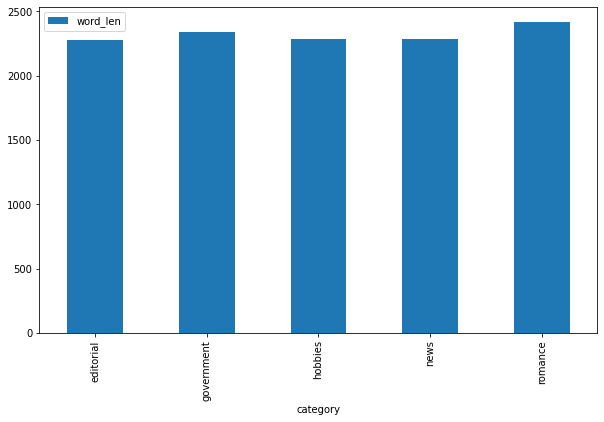

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [12]:
# an example to see difference between CountVectorizer.fit_transform and TfidfVectorizer.fit_transform
cv = CountVectorizer(stop_words=stopwords)
tv = TfidfVectorizer(stop_words=stopwords)
# sample corpus
a = "cat hat bat splat cat bat hat mat cat"
b = "cat mat cat sat"

cv_score = cv.fit_transform([a,b])
tv_score = tv.fit_transform([a,b])

#output adjust (small corpus)
def matrix_to_list(matrix):
    matrix = matrix.toarray()
    return matrix.tolist()
cv_score_list = matrix_to_list(cv_score)
print('CountVectorizer.fit_transform output: \n', cv_score_list)

tv_score_list = matrix_to_list(tv_score)
print('tfidfVectorizer.fit_transform output: \n', tv_score_list)
# https://datascience.stackexchange.com/questions/25581/what-is-the-difference-between-countvectorizer-token-counts-and-tfidftransformer#:~:text=The%20only%20difference%20is%20that%20the%20TfidfVectorizer%20%28%29,%28%29%20assigns%20a%20score%20while%20CountVectorizer%20%28%29%20counts.

CountVectorizer.fit_transform output: 
 [[2, 3, 2, 1, 0, 1], [0, 2, 0, 1, 1, 0]]
tfidfVectorizer.fit_transform output: 
 [[0.5333344767907123, 0.5692078092660131, 0.5333344767907123, 0.18973593642200434, 0.0, 0.26666723839535617], [0.0, 0.7572644142929534, 0.0, 0.3786322071464767, 0.5321543559503558, 0.0]]


**Q:** What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

**A:** The `count_text_vectors` has the integer counts of tokenized words as they appear in the corpus. The `tfidf_text_vectors` has the scored version of these counts. The score relates to the term frequency and inverse document frequency where frequently occurring tokens in all documents are penalized with the assumption of lower importance. 

Assistance from: https://enjoymachinelearning.com/blog/countvectorizer-vs-tfidfvectorizer/

---

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [13]:
nmf_text_model = NMF(n_components=5, random_state=314)
# W matrix is documents as rows adn topics as columns
  # maps documents to topics (what we are focused on)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
# H matrix is topics as rows with words as columns
  # shows how topics are made up of features/words
H_text_matrix = nmf_text_model.components_

In [14]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [15]:
# Your code here 
## Compare the NMF factorization to the original categories from the Brown Corpus
## Brown data stored in 'df'
  ## df['category'].unique() 
      ## ['editorial', 'government', 'news', 'romance', 'hobbies'],
# getting value counts
print(df['category'].value_counts())

# wordcloud comparisons function (from chapter 8 of book)
def wordcloud_topics(model, features, no_top_words=30, wc_title='wordcloud'):
  for topic, words in enumerate(model.components_):
    size={}
    largest = words.argsort()[::-1] #inverts sort order
    for i in range(0, no_top_words):
      size[features[largest[i]]] = abs(words[largest[i]])
    wc = WordCloud(background_color="black", 
                   max_words=50, width=640, height=360)
    wc.generate_from_frequencies(size)
    plt.figure(figsize=(12,6))
    plt.title(f'{wc_title} - {topic}')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

news          44
hobbies       36
government    30
romance       29
editorial     27
Name: category, dtype: int64


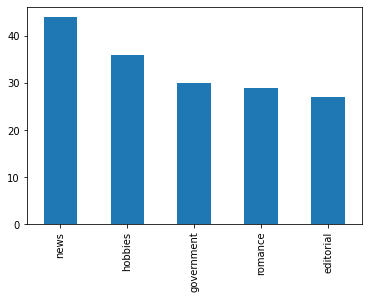

In [16]:
df['category'].value_counts().plot(kind='bar')

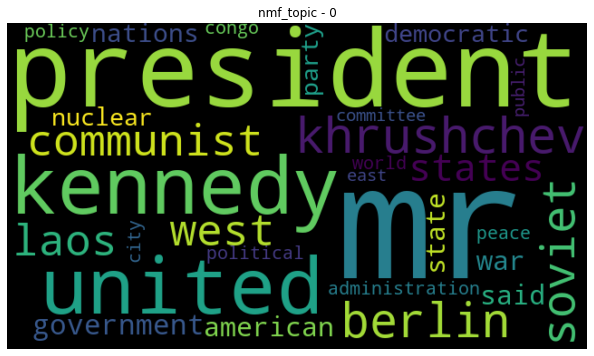

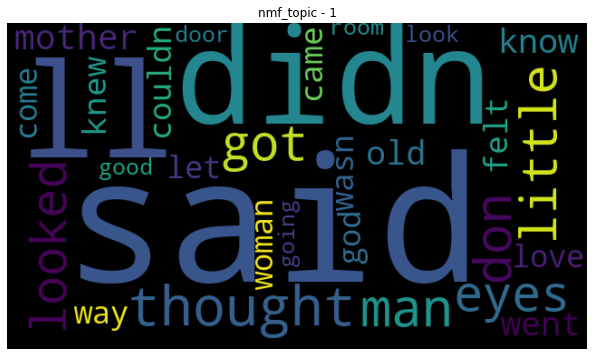

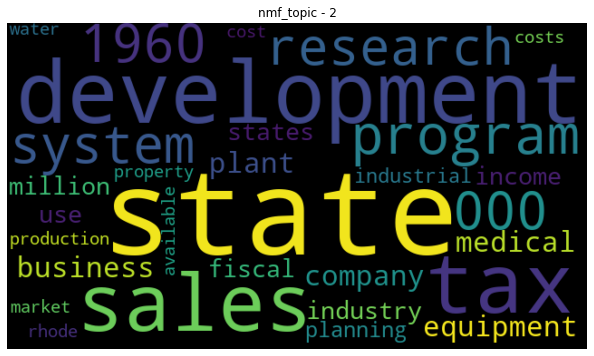

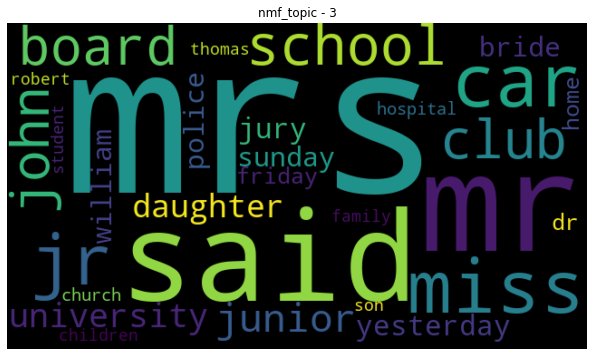

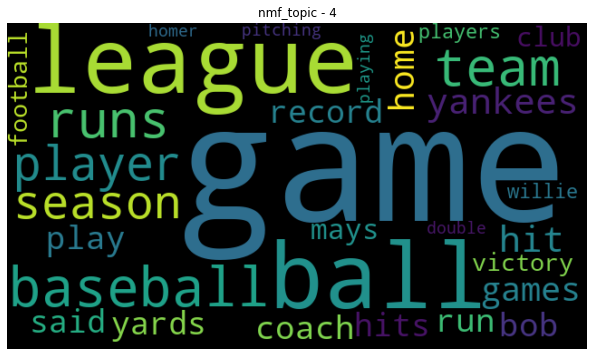

In [17]:
# making word clouds of nmf_text_model, tfidf_text_vectorizer.get_feature_names()
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names(), wc_title = "nmf_topic")

In [18]:
# looking at the W matrix 
W_text_matrix_df = pd.DataFrame(W_text_matrix)
# seeing what it looks like
W_text_matrix_df.head(5)
  # columns labeled as 0-4 for the different topics it mapped out to.
  # Each entry is probability of each article (row) belonging to each topic (column)
  # row index 0: 16.8% as 00, 0% as 1, 19.7% as 2, 0% as 3, and 2.86% as 4.

,0,1,2,3,4
0,0.168337,0.000000,0.196650,0.0,0.028598
1,0.321769,0.000000,0.000000,0.0,0.000000
2,0.273861,0.040403,0.000000,0.0,0.001421
3,0.270374,0.000000,0.048464,0.0,0.000345
4,0.200523,0.002224,0.111485,0.0,0.017609


In [19]:
# renaming columns to match nmf model labels
W_text_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
# checking:
W_text_matrix_df.head(5)


,Topic 00,Topic 01,Topic 02,Topic 03,Topic 04
0,0.168337,0.000000,0.196650,0.0,0.028598
1,0.321769,0.000000,0.000000,0.0,0.000000
2,0.273861,0.040403,0.000000,0.0,0.001421
3,0.270374,0.000000,0.048464,0.0,0.000345
4,0.200523,0.002224,0.111485,0.0,0.017609


In [20]:
# adding column to Brown data (df) that places the topic each row was placed in.
  # based on which entry had the highest value so for entry 0 that would be 02.
df['identified_topic'] = W_text_matrix_df.idxmax(axis=1)
  # idx.max(axis=1) finds column with greatest value on each row
# https://stackoverflow.com/questions/29919306/find-the-column-name-which-has-the-maximum-value-for-each-row

# looking at results
df.head()

,category,id,text,char_len,word_len,identified_topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,Topic 02
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,Topic 00
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,Topic 00
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,Topic 00
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,Topic 00


In [21]:
# making a datafrmae of just the category and the indentified topic:
dfv2 = df[['category', 'identified_topic']].copy()
# checking
# dfv2.head()
  # this worked so commenting out to look at value counts again

# view to see how many Brown documents are in each nmf topic:
dfv2.groupby('identified_topic')['category'].value_counts()

identified_topic  category  
Topic 00          editorial     20
                  news           8
                  government     4
Topic 01          romance       29
                  hobbies        8
                  editorial      4
Topic 02          government    26
                  hobbies       26
                  news          11
                  editorial      2
Topic 03          news          17
                  hobbies        1
Topic 04          news           8
                  editorial      1
                  hobbies        1
Name: category, dtype: int64

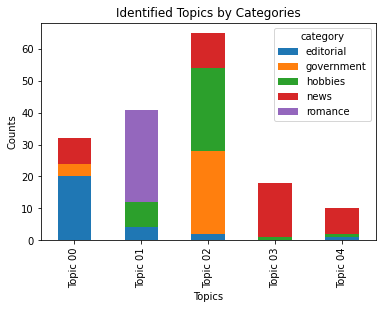

In [22]:
# plotting as stacked bar
dfv2.groupby(['identified_topic', 'category']).size().unstack().plot(kind= 'bar',
                                                                     ylabel='Counts',
                                                                     xlabel= 'Topics',
                                                                     stacked= True,
                                                                     title='Identified Topics by Categories')

**Q:** How does your five-topic NMF model compare to the original Brown categories? 

**A:** When looking at the topics as wholes, topic 02 is the most common assignemnt, followed by topic 01, topic 00. Topics 03 and 04 are greatly under represented with less than roughly half of the classifications going to them.  
* Topic 00 has common words 'mr', 'president', 'kennedy', 'united' and 'khrushchev'. This topic is most commonly filled with documents from the 'editorial' category, followed by 'news' and 'govenment' categories. Which goes along with what logically makes sense since the common words are typically associated with government and news stories which could include editorials. 
* Topic 01 has common words of 'said', 'didn', 'll', 'thought', and 'man' which were primarily from the romance category. This makes sense since these are more story telling words and romance articles would include people thinking things more than news or editorials (meaning the thoughts are written out, not that thought wasn't involved).
* Topic 02 was predominantly associated with government and hobbies categories with top words including 'state', 'development', 'tax', 'sales', 'program'. The inclusion of hobbies with government is a bit of a head scratcher but I am thinking the terms are just being used in different ways ('development' for government topic for building developments while in hobbies it could be for plans for models). 
* Topic 03 is predominantly associated with 'news' category with top words of 'mr', 'mrs', 'miss', 'said', and 'car'. When thinking of a newstory, this makes sense since a lot of reports refer to people as mr/miss/mrs last name and quote them. Car is probably in there due to number of news stories that involve car accidents. 
* Topic 04 appears very sporty with top words 'game', 'league', 'ball', 'baseball', and 'team'. This topic was primarily associated with news with some overlap with hobbies. There are a lot of news stories that cover sporting events so this is a logical overlap. 

---

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [23]:
# Your code here
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_


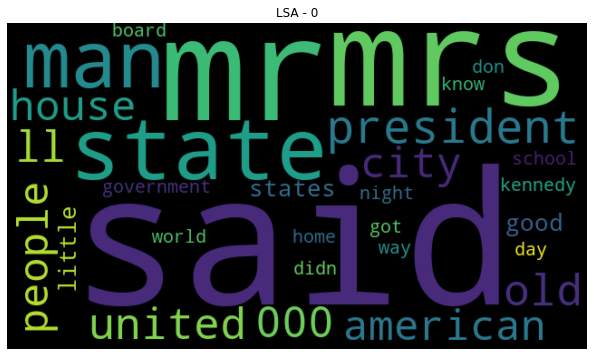

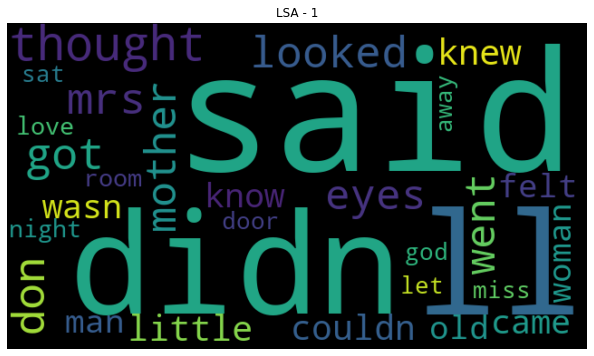

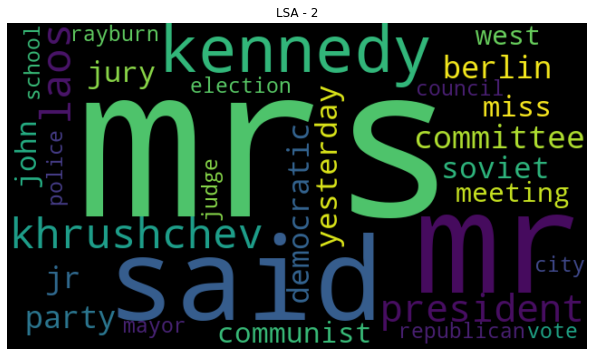

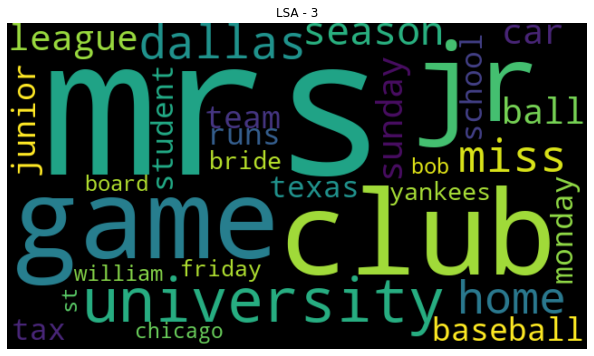

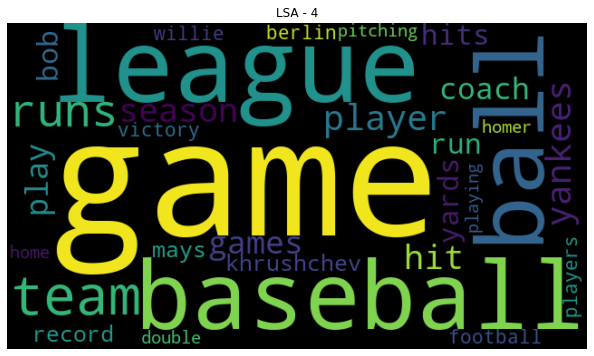

In [24]:
# wordcloud
wordcloud_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names(), wc_title = "LSA")

In [25]:
# making W matrix a dataframe
W_svd_text_matrix_df = pd.DataFrame(W_svd_text_matrix)
W_svd_text_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']

# making copy of df 
df_lsa = df.copy()
# adding column to Brown data (df) that places the topic each row was placed in.
  # based on which entry had the highest value so for entry 0 that would be 02.
df_lsa['lsa_topic'] = W_svd_text_matrix_df.idxmax(axis=1)

# selecting only category and lsa topic
df_lsa = df_lsa[['category', 'lsa_topic']]
# checking
df_lsa.head()

,category,lsa_topic
0,editorial,Topic 00
1,editorial,Topic 00
2,editorial,Topic 00
3,editorial,Topic 00
4,editorial,Topic 00


lsa_topic  category  
Topic 00   hobbies       36
           news          34
           government    30
           editorial     27
           romance       21
Topic 01   romance        8
Topic 03   news           3
Topic 04   news           7
Name: category, dtype: int64


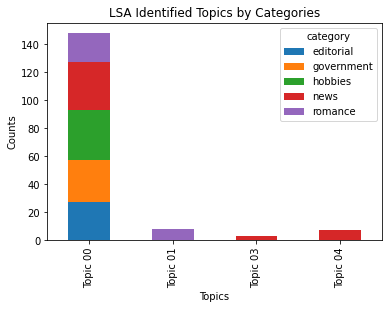

In [26]:
# view to see how many Brown documents are in each nmf topic:
print(df_lsa.groupby('lsa_topic')['category'].value_counts())

# plotting as stacked bar
df_lsa.groupby(['lsa_topic', 'category']).size().unstack().plot(kind= 'bar',
                                                                     ylabel='Counts',
                                                                     xlabel= 'Topics',
                                                                     stacked= True,
                                                                     title='LSA Identified Topics by Categories')

**Q:** How does your five-topic LSA model compare to the original Brown categories? 

**A:** Overall, Topic 00 is the most commonly identified topic (148). Topics 01, 03, and 04 are very underrepresented (less than 10) while Topic 02 is not even classified. 
* Topic 01 was classed with only eight 'romance' category entries.
* Topic 03 had only three entries, each of them in the 'news' category.
* Topic 04 had seven entries, each from the 'news' category.
* Topic 00 is where the majority of the documents were sorted and are mostly evenly split between the different categories.


In [27]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


**Q:** What is your interpretation of the display topics output? 

**A:** The display topics output gives the keywords and percent frequency of them in the different topics. The supposed keyword 'said' appears as a keyword for Topics 00 (.44), 01 (3.89), and 02 (1.06) while mr and mrs are also spread through more than one topic, indicating there is a lot of overlap of keywords. 

---

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [28]:
# Fit your LDA model here
lda_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

In [29]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


**Q:** What inference do you draw from the displayed topics for your LDA model? 

**A:**  Overall, there is more variety in the keywords than in the LSA model where we saw 'said', 'mr', and 'mrs' in several topics. 
* Topic 04 the keywords are 'states', 'state', 'united', 'shall', and 'government' so I would guess that this topic is primarily filled with 'government' category documents. Though there could be some 'news' category documents in there, though the keyword of 'shall' is presumably not in those documents since I don't think reporters say 'shall' very often. 
* Topic 03 with keywords of 'feed', 'college', 'general', 'university', and 'work' is likely primarily 'news' or 'editorial' categorized documents. 
* Topic 00 with words like 'said', 'mrs', and 'little' makes me think it will be primarily 'romance' category documents because those don't seem like 'news' or government or hobbies type words. 
* Topics 01 and 02 are a bit harder for me to make guesses about popular categories since they have similar words types. However, they probably both will have a lot of 'news', 'editorial', and 'government' categorized documents. 




In [30]:
# making W matrix a dataframe
W_lda_matrix_df = pd.DataFrame(W_lda_matrix)
W_lda_matrix_df.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']

# making copy of df 
df_lda = df.copy()
# adding column to Brown data (df) that places the topic each row was placed in.
  # based on which entry had the highest value so for entry 0 that would be 02.
df_lda['lda_topic'] = W_lda_matrix_df.idxmax(axis=1)

# selecting only category and lsa topic
df_lda = df_lda[['category', 'lda_topic']]
# checking
df_lda.head()

,category,lda_topic
0,editorial,Topic 02
1,editorial,Topic 02
2,editorial,Topic 02
3,editorial,Topic 02
4,editorial,Topic 02


lda_topic  category  
Topic 00   romance       28
           hobbies       11
           news           4
           editorial      3
           government     1
Topic 01   government    12
           hobbies        9
           news           3
           editorial      1
Topic 02   news          32
           editorial     21
           government     3
           hobbies        2
           romance        1
Topic 03   hobbies        8
           government     4
           news           3
           editorial      2
Topic 04   government    10
           hobbies        6
           news           2
Name: category, dtype: int64


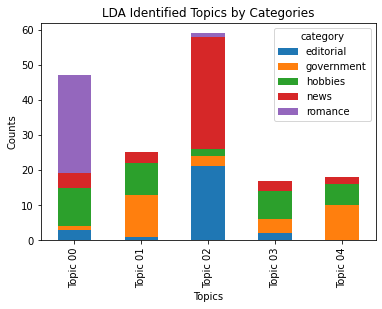

In [31]:
# view to see how many Brown documents are in each nmf topic:
print(df_lda.groupby('lda_topic')['category'].value_counts())

# plotting as stacked bar
df_lda.groupby(['lda_topic', 'category']).size().unstack().plot(kind= 'bar',
                                                                     ylabel='Counts',
                                                                     xlabel= 'Topics',
                                                                     stacked= True,
                                                                     title='LDA Identified Topics by Categories')

**Q:** Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

**A:** Overall, the LDA model had a more even spread of topic splittings with the least populated being Topic 03 with 17 counts and the most populated being Topic 02 with 47. This spread is similar to the original spread of categories which ranged from 27 (editorial) to 44 (news). 
* Topic 00 is primarily filled with 'romance' categorized documents followed by 'hobbies' categorized. 
* Topic 01 is mostly 'government' followed by 'hobbies' while 'news' and 'editorial' making slight appearances.
* Topic 02 is mostly 'news' followed closely 'editorial' while 'government', 'hobbies', and 'romance' barely make appearances.
* Topic 03 is mostly 'hobbies' followed by government, news, and editorial. 
* Topic 04 is mostly 'government' then 'hobbies' and 'news'. 

In [32]:
lda_display = pyLDAvis.sklearn.prepare(lda_model, count_text_vectors, 
                                       count_text_vectorizer, 
                                       sort_topics=False)

In [33]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 
* The largest size in the Intertopic Distance map is for PC3 or Topic 02, which incorporates 32% of the tokens. 
  * This is dominated by the keyword 'said' followed by 'mr' and 'president'. The overall term frequency (blue) and estimated term frequency within topic (red) follow the same decreasing trend with few upticks in overall term frequency. 
* Meanwhile the smallest PC is PC5 or Topic 04 which only incorporates 12.3% of the tokens (PC4 or Topic 03 is barely larger at 12.4%). 
  * PC5 is dominated by keywords 'states', 'state', and 'united'. The overall term frequency does not follow the trend set by the estimated term frequency because the overall frequncy has several large spikes (see 'use', 'board', and 'day' terms for prime examples).
* PC4 (topic 03) and PC2 (topic 01) are closely related to eachother based on their nearness in the distance map. 
* PC1 is least related to PC5, PC4, and PC2 since they are further apart from eachother. 
* PC3 is centrally located and roughly mid range to all the other PCs. 